# Project 4: Deep Learning Systems (P4)

Author: Christopher Aaron O'Hara

Dataset: UCI RT-IoT2022 (ID 942)
Source: https://archive.ics.uci.edu/dataset/942/rt-iot2022

Task: Supervised binary classification for IIoT network intrusion detection (`attack` vs `benign`) using a Transformer-based tabular model in PyTorch.

Project Repository: https://github.com/Ohara124c41/deep-learning-iot-intrusion

This notebook aligns to the DevSecAIOps local-cloud IIoT/OT capstone horizon: robust detection signals, reproducibility controls, and governance-oriented evaluation.

## Motivation

In local-cloud IIoT/OT operations, network telemetry volumes typically exceed manual analysis capacity. A deep model that can prioritize likely attack records can reduce triage latency, but only if the model is trained and evaluated with explicit controls for class imbalance, overfitting, and reproducibility.

This experiment focuses on implementation quality and controlled comparison rather than headline accuracy. The objective is to produce a reliable deep learning building block that can later feed generative and agentic orchestration layers in an end-to-end DevSecAIOps pipeline.

## 1) Setup and Standalone Dependency Bootstrap

This cell installs missing dependencies so the notebook can run in a clean environment.

This cell validates package availability before modeling. RT-IoT2022 processing and Transformer training require consistent dependencies (`torch`, `ucimlrepo`, `sklearn`), so this check prevents hidden environment drift.

In [50]:
import importlib.util
import subprocess
import sys

REQUIRED_PACKAGES = {
    'numpy': 'numpy',
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'sklearn': 'scikit-learn',
    'torch': 'torch',
    'ucimlrepo': 'ucimlrepo',
}

OPTIONAL_PACKAGES = {
    'aif360': 'aif360',
}


def ensure_packages(required):
    missing = []
    for import_name, pip_name in required.items():
        if importlib.util.find_spec(import_name) is None:
            missing.append(pip_name)

    status = {'missing_before_install': missing.copy(), 'installed_now': []}
    if missing:
        cmd = [sys.executable, '-m', 'pip', 'install', '--quiet'] + missing
        subprocess.check_call(cmd)
        status['installed_now'] = missing
    return status


def ensure_optional_packages(optional_required):
    status = {}
    for import_name, pip_name in optional_required.items():
        if importlib.util.find_spec(import_name) is not None:
            status[pip_name] = 'available'
            continue
        try:
            cmd = [sys.executable, '-m', 'pip', 'install', '--quiet', pip_name]
            subprocess.check_call(cmd)
            status[pip_name] = 'installed'
        except Exception as e:
            status[pip_name] = f'install_failed: {e}'
    return status


bootstrap_status = ensure_packages(REQUIRED_PACKAGES)
optional_bootstrap_status = ensure_optional_packages(OPTIONAL_PACKAGES)
print('Bootstrap status:', bootstrap_status)
print('Optional bootstrap status:', optional_bootstrap_status)

Bootstrap status: {'missing_before_install': [], 'installed_now': []}
Optional bootstrap status: {'aif360': 'available'}


If the bootstrap status shows no unresolved package failures, the environment is ready for deterministic experiment execution.

## 2) Imports and Reproducibility Controls

This import block defines the full analytics stack used for the experiment: data handling, deep learning, metrics, and optional fairness diagnostics. Keeping imports explicit supports traceability and reproducibility.

In [51]:
from pathlib import Path
import os
import re
import math
import random
import warnings
from dataclasses import dataclass

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    brier_score_loss,
    mean_squared_error,
    precision_recall_curve,
    balanced_accuracy_score,
    matthews_corrcoef,
    log_loss,
)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from ucimlrepo import fetch_ucirepo

# Optional fairness toolkit
AIF360_AVAILABLE = False
AIF360_IMPORT_ERROR = None
try:
    from aif360.datasets import BinaryLabelDataset
    from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
    AIF360_AVAILABLE = True
except Exception as e:
    AIF360_IMPORT_ERROR = str(e)

print({'AIF360_AVAILABLE': AIF360_AVAILABLE, 'AIF360_IMPORT_ERROR': AIF360_IMPORT_ERROR})

{'AIF360_AVAILABLE': True, 'AIF360_IMPORT_ERROR': None}


Successful imports confirm that the full workflow stack is available, including optional AIF360 support for subgroup-risk diagnostics.

This cell fixes random seeds and device selection to make runs repeatable. Deterministic behavior is important here because later model comparisons rely on small metric differences.

In [52]:
# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print({'DEVICE': str(DEVICE), 'torch_version': torch.__version__})

{'DEVICE': 'cpu', 'torch_version': '2.9.1+cpu'}


The printed device and seed settings establish a reproducible baseline for comparing model runs.

## 3) Configuration

This configuration establishes runtime limits and dataset controls (including row cap). The cap keeps experiments feasible while still using a large IIoT sample.

In [53]:
# Paths
DATA_DIR = Path('data')
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

RAW_DATA_PATH = RAW_DIR / 'rtiot2022_raw.csv'

# Dataset controls
UCI_DATASET_ID = 942
AUTO_DOWNLOAD = True
FORCE_REFRESH = False
MAX_ROWS = 120000  # runtime control, set None for full data

# Label mapping controls for binary task
BENIGN_KEYWORDS = ['normal', 'benign', 'mqtt', 'thing_speak', 'thingspeak', 'wipro_bulb', 'amazon_alexa', 'alexa']

# Training controls
BATCH_SIZE = 512
EPOCHS = 10
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EARLY_STOPPING_PATIENCE = 3

print({
    'UCI_DATASET_ID': UCI_DATASET_ID,
    'AUTO_DOWNLOAD': AUTO_DOWNLOAD,
    'MAX_ROWS': MAX_ROWS,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'LEARNING_RATE': LEARNING_RATE,
})

{'UCI_DATASET_ID': 942, 'AUTO_DOWNLOAD': True, 'MAX_ROWS': 120000, 'BATCH_SIZE': 512, 'EPOCHS': 10, 'LEARNING_RATE': 0.001}


These configuration values define the experimental envelope (dataset size, epochs, LR, and caching behavior) for this run.

## 4) Data Ingestion and Inspection

This ingestion step loads RT-IoT2022 and creates a cached local copy. The objective is stable access to a public, non-synthetic IIoT security dataset for deep learning experiments.

In [54]:
def normalize_label(value):
    text = str(value).lower().strip()
    text = re.sub(r'[^a-z0-9]+', '_', text)
    return text.strip('_')


def is_benign_label(label_norm, benign_keywords):
    return any(k in label_norm for k in benign_keywords)


def load_rtiot2022_dataframe(auto_download=True, force_refresh=False):
    if RAW_DATA_PATH.exists() and not force_refresh:
        df_local = pd.read_csv(RAW_DATA_PATH)
        return df_local, {'source': 'local_cache', 'path': str(RAW_DATA_PATH)}

    if not auto_download:
        raise FileNotFoundError(
            f'RT-IoT2022 not found at {RAW_DATA_PATH}. Enable AUTO_DOWNLOAD or place local CSV.'
        )

    ds = fetch_ucirepo(id=UCI_DATASET_ID)
    X = ds.data.features.copy()
    y = ds.data.targets

    if isinstance(y, pd.DataFrame):
        y_series = y.iloc[:, 0].astype(str)
        y_name = y.columns[0]
    else:
        y_series = pd.Series(y).astype(str)
        y_name = 'label_raw'

    df = X.copy()
    df[y_name] = y_series.values

    RAW_DIR.mkdir(parents=True, exist_ok=True)
    df.to_csv(RAW_DATA_PATH, index=False)

    return df, {'source': 'uci_fetch', 'path': str(RAW_DATA_PATH), 'target_col': y_name}


raw_df, ingest_meta = load_rtiot2022_dataframe(auto_download=AUTO_DOWNLOAD, force_refresh=FORCE_REFRESH)
print('Ingestion metadata:', ingest_meta)
print('Raw shape:', raw_df.shape)
raw_df.head()

Ingestion metadata: {'source': 'local_cache', 'path': 'data\\raw\\rtiot2022_raw.csv'}
Raw shape: (123117, 84)


,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,0.281148,...,0.0,29729182.96,29729182.96,29729182.96,29729182.96,0.0,64240,26847,502,MQTT_Publish
1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,0.282277,...,0.0,29855277.06,29855277.06,29855277.06,29855277.06,0.0,64240,26847,502,MQTT_Publish
2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,0.280164,...,0.0,29842149.02,29842149.02,29842149.02,29842149.02,0.0,64240,26847,502,MQTT_Publish
3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,0.281593,...,0.0,29913774.97,29913774.97,29913774.97,29913774.97,0.0,64240,26847,502,MQTT_Publish
4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,0.282111,...,0.0,29814704.90,29814704.90,29814704.90,29814704.90,0.0,64240,26847,502,MQTT_Publish


Current run loaded RT-IoT2022 successfully and showed the expected high-dimensional network-flow schema; this confirms dataset suitability for tabular deep learning.

This cell normalizes labels and builds the binary attack target. It is the core problem-framing step, so target balance is inspected immediately.

In [55]:
# Identify raw label column (assume last non-numeric candidate if not explicit)
candidate_label_cols = []
for col in raw_df.columns:
    if raw_df[col].dtype == 'object':
        candidate_label_cols.append(col)

if 'Attack_type' in raw_df.columns:
    label_col = 'Attack_type'
elif 'label' in raw_df.columns:
    label_col = 'label'
elif len(candidate_label_cols) > 0:
    label_col = candidate_label_cols[-1]
else:
    label_col = raw_df.columns[-1]

print('Selected label column:', label_col)

model_df = raw_df.copy()
model_df['label_raw'] = model_df[label_col].astype(str)
model_df['label_norm'] = model_df['label_raw'].map(normalize_label)
model_df['attack_binary'] = (~model_df['label_norm'].map(lambda x: is_benign_label(x, BENIGN_KEYWORDS))).astype(int)

if model_df['attack_binary'].nunique() < 2:
    unique_labels = model_df['label_norm'].value_counts().head(25)
    raise ValueError(
        'Binary mapping produced a single class. Review BENIGN_KEYWORDS. '        f'Label preview: {unique_labels.to_dict()}'
    )

if MAX_ROWS is not None and len(model_df) > MAX_ROWS:
    model_df = model_df.sample(n=MAX_ROWS, random_state=RANDOM_STATE).reset_index(drop=True)

label_counts = model_df['attack_binary'].value_counts().sort_index()
print('Modeling shape:', model_df.shape)
print('Binary target counts:', label_counts.to_dict())
print('Attack rate:', float(model_df['attack_binary'].mean()))

model_df[['label_raw', 'label_norm', 'attack_binary']].head(10)

Selected label column: Attack_type
Modeling shape: (120000, 87)
Binary target counts: {0: 12171, 1: 107829}
Attack rate: 0.898575


,label_raw,label_norm,attack_binary
0,DOS_SYN_Hping,dos_syn_hping,1
1,DOS_SYN_Hping,dos_syn_hping,1
2,DOS_SYN_Hping,dos_syn_hping,1
3,MQTT_Publish,mqtt_publish,0
4,DOS_SYN_Hping,dos_syn_hping,1
5,DOS_SYN_Hping,dos_syn_hping,1
6,DOS_SYN_Hping,dos_syn_hping,1
7,DOS_SYN_Hping,dos_syn_hping,1
8,NMAP_XMAS_TREE_SCAN,nmap_xmas_tree_scan,1
9,Thing_Speak,thing_speak,0


Current run produced 120,000 rows with attack-heavy balance (~0.899 attack rate), which explains why precision/recall behavior can differ from balanced settings.

This sample display checks that transformed labels and selected features look plausible before preprocessing and training.

In [56]:
# Representative sample rows
sample_cols = model_df.columns[: min(10, len(model_df.columns))].tolist() + ['label_raw', 'attack_binary']
sample_cols = list(dict.fromkeys(sample_cols))
model_df[sample_cols].sample(n=min(5, len(model_df)), random_state=RANDOM_STATE)

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,label_raw,attack_binary
71787,1759,21,tcp,-,0.000001,1,1,1,0,838860.800000,DOS_SYN_Hping,1
67218,8209,21,tcp,-,0.000003,1,1,1,0,322638.769200,DOS_SYN_Hping,1
54066,811,21,tcp,-,0.000002,1,1,1,0,524288.000000,DOS_SYN_Hping,1
7168,38061,21,tcp,-,0.000001,1,1,1,0,838860.800000,DOS_SYN_Hping,1
29618,34133,1883,tcp,mqtt,43.102887,9,5,3,3,0.208803,MQTT_Publish,0


Sample records show the binary label mapping is active and traceable from original labels (`label_raw`) to `attack_binary`.

### Analysis

Ingestion completed from the local cache (`data/raw/rtiot2022_raw.csv`) with a raw shape of **123,117 x 84**. After deterministic runtime capping and label normalization, the modeling frame is **120,000 x 87**, with class counts **benign=12,171** and **attack=107,829** (attack rate **0.898575**). This confirms a large, imbalanced binary detection setup appropriate for a deep-learning intrusion triage task.

## 5) Preprocessing Pipeline

Strategy:
- Keep preprocessing deterministic and train-only fitted (to avoid leakage).
- Split into train/validation/test with stratification by attack label.
- Standardize numeric features and integer-encode categorical features for Transformer inputs.

This preprocessing pipeline creates train/validation/test splits and feature encodings. The goal is leakage-safe preparation with consistent transformation across splits.

In [57]:
# Feature selection
exclude_cols = {'attack_binary', 'label_raw', 'label_norm', label_col}
feature_cols = [c for c in model_df.columns if c not in exclude_cols]

X = model_df[feature_cols].copy()
y = model_df['attack_binary'].astype(int).copy()

# Split: 70 / 15 / 15 with stratification
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y
)
val_ratio_of_temp = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_ratio_of_temp, random_state=RANDOM_STATE, stratify=y_temp
)

numeric_cols = X_train.select_dtypes(include=[np.number, 'bool']).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

# Numeric preprocessing
train_num = X_train[numeric_cols].copy() if numeric_cols else pd.DataFrame(index=X_train.index)
val_num = X_val[numeric_cols].copy() if numeric_cols else pd.DataFrame(index=X_val.index)
test_num = X_test[numeric_cols].copy() if numeric_cols else pd.DataFrame(index=X_test.index)

if len(numeric_cols) > 0:
    train_num = train_num.replace([np.inf, -np.inf], np.nan)
    val_num = val_num.replace([np.inf, -np.inf], np.nan)
    test_num = test_num.replace([np.inf, -np.inf], np.nan)

    num_medians = train_num.median(numeric_only=True)
    train_num = train_num.fillna(num_medians)
    val_num = val_num.fillna(num_medians)
    test_num = test_num.fillna(num_medians)

    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(train_num)
    X_val_num = scaler.transform(val_num)
    X_test_num = scaler.transform(test_num)
else:
    scaler = None
    X_train_num = np.zeros((len(X_train), 1), dtype=np.float32)
    X_val_num = np.zeros((len(X_val), 1), dtype=np.float32)
    X_test_num = np.zeros((len(X_test), 1), dtype=np.float32)

# Categorical preprocessing
cat_maps = {}
cat_cardinalities = []

def encode_categorical(df_part, col, mapping):
    values = df_part[col].astype(str).fillna('MISSING')
    return values.map(lambda v: mapping.get(v, 0)).astype(np.int64).values

X_train_cat_parts = []
X_val_cat_parts = []
X_test_cat_parts = []

for col in categorical_cols:
    train_values = X_train[col].astype(str).fillna('MISSING')
    unique_vals = sorted(train_values.unique().tolist())
    mapping = {v: i + 1 for i, v in enumerate(unique_vals)}
    cat_maps[col] = mapping
    cat_cardinalities.append(len(unique_vals) + 1)  # +1 for unknown bucket 0

    X_train_cat_parts.append(encode_categorical(X_train, col, mapping))
    X_val_cat_parts.append(encode_categorical(X_val, col, mapping))
    X_test_cat_parts.append(encode_categorical(X_test, col, mapping))

if len(categorical_cols) > 0:
    X_train_cat = np.vstack(X_train_cat_parts).T
    X_val_cat = np.vstack(X_val_cat_parts).T
    X_test_cat = np.vstack(X_test_cat_parts).T
else:
    X_train_cat = np.zeros((len(X_train), 0), dtype=np.int64)
    X_val_cat = np.zeros((len(X_val), 0), dtype=np.int64)
    X_test_cat = np.zeros((len(X_test), 0), dtype=np.int64)

X_train_num = np.asarray(X_train_num, dtype=np.float32)
X_val_num = np.asarray(X_val_num, dtype=np.float32)
X_test_num = np.asarray(X_test_num, dtype=np.float32)

y_train_arr = y_train.values.astype(np.float32)
y_val_arr = y_val.values.astype(np.float32)
y_test_arr = y_test.values.astype(np.float32)

vnv_preprocess = {
    'train_rows': int(len(X_train_num)),
    'val_rows': int(len(X_val_num)),
    'test_rows': int(len(X_test_num)),
    'num_features': int(X_train_num.shape[1]),
    'cat_features': int(X_train_cat.shape[1]),
    'train_attack_rate': float(y_train_arr.mean()),
    'val_attack_rate': float(y_val_arr.mean()),
    'test_attack_rate': float(y_test_arr.mean()),
}
print('V&V preprocess:', vnv_preprocess)

V&V preprocess: {'train_rows': 84000, 'val_rows': 18000, 'test_rows': 18000, 'num_features': 81, 'cat_features': 2, 'train_attack_rate': 0.8985833525657654, 'val_attack_rate': 0.8985555768013, 'test_attack_rate': 0.8985555768013}


The split produced 84k/18k/18k rows with stable attack rates and 81 numeric + 2 categorical model features, indicating a consistent preprocessing pipeline.

### Analysis

Preprocessing produced stable split sizes (**train=84,000**, **val=18,000**, **test=18,000**) with nearly identical attack rates across splits (train **0.89858**, val **0.89856**, test **0.89856**). The feature space includes **81 numeric** and **2 categorical** predictors, which matches the tabular-Transformer design (numeric projection plus categorical embeddings). This indicates the split/transform pipeline is leakage-aware and balanced for controlled comparison.

## 5B) Persist Processed Modeling Artifacts

To improve reproducibility and speed for reruns, this section writes the prepared train/validation/test arrays and metadata into `data/processed/`. This keeps preprocessing deterministic and auditable without recomputing every transformation from raw data.

In [58]:
import json

EXPORT_PROCESSED_ARTIFACTS = True

processed_manifest = None
if EXPORT_PROCESSED_ARTIFACTS:
    artifact_prefix = f'rtiot2022_binary_rs{RANDOM_STATE}_n{len(model_df)}'
    arrays_path = PROCESSED_DIR / f'{artifact_prefix}_split_arrays.npz'
    meta_path = PROCESSED_DIR / f'{artifact_prefix}_metadata.json'
    num_cols_path = PROCESSED_DIR / f'{artifact_prefix}_numeric_columns.csv'
    cat_cols_path = PROCESSED_DIR / f'{artifact_prefix}_categorical_columns.csv'

    np.savez_compressed(
        arrays_path,
        X_train_num=X_train_num,
        X_val_num=X_val_num,
        X_test_num=X_test_num,
        X_train_cat=X_train_cat,
        X_val_cat=X_val_cat,
        X_test_cat=X_test_cat,
        y_train=y_train_arr,
        y_val=y_val_arr,
        y_test=y_test_arr,
    )

    pd.DataFrame({'numeric_feature': numeric_cols}).to_csv(num_cols_path, index=False)
    pd.DataFrame({'categorical_feature': categorical_cols}).to_csv(cat_cols_path, index=False)

    metadata = {
        'artifact_prefix': artifact_prefix,
        'random_state': int(RANDOM_STATE),
        'max_rows': int(len(model_df)),
        'split_rows': {
            'train': int(len(y_train_arr)),
            'val': int(len(y_val_arr)),
            'test': int(len(y_test_arr)),
        },
        'num_features': int(X_train_num.shape[1]),
        'cat_features': int(X_train_cat.shape[1]),
        'numeric_columns_file': str(num_cols_path.as_posix()),
        'categorical_columns_file': str(cat_cols_path.as_posix()),
        'arrays_file': str(arrays_path.as_posix()),
        'categorical_cardinalities': [int(x) for x in cat_cardinalities],
    }

    with open(meta_path, 'w', encoding='utf-8') as f:
        json.dump(metadata, f, indent=2)

    processed_manifest = {
        'arrays_file': str(arrays_path),
        'metadata_file': str(meta_path),
        'numeric_columns_file': str(num_cols_path),
        'categorical_columns_file': str(cat_cols_path),
    }

print('Processed artifact export:', processed_manifest if processed_manifest else 'disabled')

Processed artifact export: {'arrays_file': 'data\\processed\\rtiot2022_binary_rs42_n120000_split_arrays.npz', 'metadata_file': 'data\\processed\\rtiot2022_binary_rs42_n120000_metadata.json', 'numeric_columns_file': 'data\\processed\\rtiot2022_binary_rs42_n120000_numeric_columns.csv', 'categorical_columns_file': 'data\\processed\\rtiot2022_binary_rs42_n120000_categorical_columns.csv'}


Processed artifacts were exported successfully to `data/processed/` with prefix `rtiot2022_binary_rs42_n120000`, including compressed split arrays (`.npz`), a metadata manifest (`.json`), and feature-name files (`.csv`). This creates a deterministic handoff point for reruns and downstream modules without repeating raw preprocessing.

## 6) PyTorch Dataset, DataLoaders, and Model Definition

This cell packages preprocessed arrays into PyTorch datasets/loaders so the model can be trained in mini-batches efficiently.

In [59]:
class TabularTensorDataset(Dataset):
    def __init__(self, x_num, x_cat, y):
        self.x_num = torch.tensor(x_num, dtype=torch.float32)
        self.x_cat = torch.tensor(x_cat, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_num[idx], self.x_cat[idx], self.y[idx]


train_ds = TabularTensorDataset(X_train_num, X_train_cat, y_train_arr)
val_ds = TabularTensorDataset(X_val_num, X_val_cat, y_val_arr)
test_ds = TabularTensorDataset(X_test_num, X_test_cat, y_test_arr)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print({
    'train_batches': len(train_loader),
    'val_batches': len(val_loader),
    'test_batches': len(test_loader),
})

{'train_batches': 165, 'val_batches': 36, 'test_batches': 36}


Batch loader counts confirm the data pipeline is ready for epoch-based training and evaluation.

This defines the Transformer architecture used for tabular IIoT detection, combining numeric projection and categorical embeddings with attention layers.

In [60]:
class TabularTransformerBinary(nn.Module):
    def __init__(self, num_numeric, cat_cardinalities, d_model=64, n_heads=4, n_layers=2, ff_dim=128, dropout=0.1):
        super().__init__()
        self.num_numeric = num_numeric
        self.cat_cardinalities = cat_cardinalities

        self.numeric_proj = nn.Linear(num_numeric, d_model)

        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(cardinality, d_model, padding_idx=0) for cardinality in cat_cardinalities
        ])

        total_tokens = 1 + 1 + len(cat_cardinalities)  # [CLS] + numeric + categorical tokens
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_embedding = nn.Parameter(torch.zeros(1, total_tokens, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            activation='gelu',
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, 1)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.normal_(self.cls_token, mean=0.0, std=0.02)
        nn.init.normal_(self.pos_embedding, mean=0.0, std=0.02)

    def forward(self, x_num, x_cat):
        batch_size = x_num.size(0)

        num_token = self.numeric_proj(x_num).unsqueeze(1)

        cat_tokens = []
        for i, emb in enumerate(self.cat_embeddings):
            cat_tokens.append(emb(x_cat[:, i]).unsqueeze(1))

        if len(cat_tokens) > 0:
            feat_tokens = torch.cat([num_token] + cat_tokens, dim=1)
        else:
            feat_tokens = num_token

        cls = self.cls_token.expand(batch_size, -1, -1)
        tokens = torch.cat([cls, feat_tokens], dim=1)

        tokens = tokens + self.pos_embedding[:, :tokens.size(1), :]
        tokens = self.dropout(tokens)
        encoded = self.encoder(tokens)
        cls_out = encoded[:, 0, :]

        logits = self.classifier(cls_out).squeeze(1)
        return logits

The model definition compiles a valid attention-based architecture for mixed tabular inputs.

### Architecture rationale

A Transformer encoder is used to model interactions across heterogeneous feature tokens (numeric projection + categorical embeddings). This architecture aligns with the capstone direction toward sequence/attention-based systems and supports a controlled regularization experiment without changing task framing.

## 7) Training and Evaluation Utilities

This utility block defines the training loop and expanded metrics (including RMSE/Brier/MCC/specificity). These functions drive all baseline, ablation, and ensemble evaluations.

In [61]:
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    y_pred = (y_prob >= threshold).astype(int)

    out = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
    }

    try:
        out['mcc'] = matthews_corrcoef(y_true, y_pred)
    except Exception:
        out['mcc'] = np.nan

    try:
        out['roc_auc'] = roc_auc_score(y_true, y_prob)
    except Exception:
        out['roc_auc'] = np.nan

    try:
        out['pr_auc'] = average_precision_score(y_true, y_prob)
    except Exception:
        out['pr_auc'] = np.nan

    try:
        out['brier'] = brier_score_loss(y_true, y_prob)
    except Exception:
        out['brier'] = np.nan

    try:
        out['rmse_prob'] = math.sqrt(mean_squared_error(y_true, y_prob))
    except Exception:
        out['rmse_prob'] = np.nan

    try:
        eps = 1e-9
        out['log_loss'] = log_loss(y_true, np.clip(y_prob, eps, 1 - eps))
    except Exception:
        out['log_loss'] = np.nan

    # Confusion-derived rates
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        out['tn'] = float(tn)
        out['fp'] = float(fp)
        out['fn'] = float(fn)
        out['tp'] = float(tp)
        out['specificity'] = float(tn / (tn + fp)) if (tn + fp) > 0 else np.nan
        out['fpr'] = float(fp / (fp + tn)) if (fp + tn) > 0 else np.nan
        out['fnr'] = float(fn / (fn + tp)) if (fn + tp) > 0 else np.nan
        out['npv'] = float(tn / (tn + fn)) if (tn + fn) > 0 else np.nan
        if not np.isnan(out['specificity']):
            out['youden_j'] = float(out['recall'] + out['specificity'] - 1)
        else:
            out['youden_j'] = np.nan
    except Exception:
        out['tn'] = out['fp'] = out['fn'] = out['tp'] = np.nan
        out['specificity'] = out['fpr'] = out['fnr'] = out['npv'] = out['youden_j'] = np.nan

    out['threshold'] = threshold
    return out


def run_epoch(model, dataloader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    losses = []
    all_probs = []
    all_targets = []

    for x_num, x_cat, y_batch in dataloader:
        x_num = x_num.to(DEVICE)
        x_cat = x_cat.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            logits = model(x_num, x_cat)
            loss = criterion(logits, y_batch)
            probs = torch.sigmoid(logits)

            if is_train:
                loss.backward()
                optimizer.step()

        losses.append(loss.item())
        all_probs.append(probs.detach().cpu().numpy())
        all_targets.append(y_batch.detach().cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)

    metrics = compute_metrics(all_targets, all_probs, threshold=0.5)
    metrics['loss'] = float(np.mean(losses))
    return metrics, all_targets, all_probs


def train_model(config, run_name):
    model = TabularTransformerBinary(
        num_numeric=X_train_num.shape[1],
        cat_cardinalities=cat_cardinalities,
        d_model=config['d_model'],
        n_heads=config['n_heads'],
        n_layers=config['n_layers'],
        ff_dim=config['ff_dim'],
        dropout=config['dropout'],
    ).to(DEVICE)

    pos_count = max(1.0, float(y_train_arr.sum()))
    neg_count = max(1.0, float(len(y_train_arr) - y_train_arr.sum()))

    use_pos_weight = config.get('use_pos_weight', True)
    if use_pos_weight:
        pos_weight_value = neg_count / pos_count
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight_value, device=DEVICE))
    else:
        criterion = nn.BCEWithLogitsLoss()

    optimizer_name = config.get('optimizer', 'adam').lower()
    if optimizer_name == 'adamw':
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay'],
        )
    else:
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay'],
        )

    history = []
    best_state = None
    best_val_f1 = -1.0
    no_improve = 0

    for epoch in range(1, config['epochs'] + 1):
        train_metrics, _, _ = run_epoch(model, train_loader, criterion, optimizer=optimizer)
        val_metrics, _, _ = run_epoch(model, val_loader, criterion, optimizer=None)

        row = {'epoch': epoch, 'run': run_name}
        row.update({f'train_{k}': v for k, v in train_metrics.items()})
        row.update({f'val_{k}': v for k, v in val_metrics.items()})
        history.append(row)

        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1

        print(
            f"[{run_name}] epoch={epoch:02d} "
            f"train_loss={train_metrics['loss']:.4f} val_loss={val_metrics['loss']:.4f} "
            f"val_f1={val_metrics['f1']:.4f} val_pr_auc={val_metrics['pr_auc']:.4f}"
        )

        if no_improve >= EARLY_STOPPING_PATIENCE:
            print(f'[{run_name}] Early stopping at epoch {epoch}.')
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    val_best_metrics, y_val_true, y_val_prob = run_epoch(model, val_loader, criterion, optimizer=None)
    test_metrics, y_test_true, y_test_prob = run_epoch(model, test_loader, criterion, optimizer=None)

    return {
        'model': model,
        'history': pd.DataFrame(history),
        'val_metrics': val_best_metrics,
        'test_metrics': test_metrics,
        'y_val_true': y_val_true,
        'y_val_prob': y_val_prob,
        'y_test_true': y_test_true,
        'y_test_prob': y_test_prob,
    }

Training/evaluation utilities are standardized across baseline, ablation, and ensemble tracks, enabling comparable metrics.

## 8) Controlled Experimental Comparison

Controlled design requirement:
- Baseline and experimental models are identical except for one major aspect.
- Changed aspect: **dropout rate** (regularization strategy).

Baseline: dropout = 0.10
Experimental: dropout = 0.30

All other settings (dataset split, optimizer, learning rate, architecture depth/width, epochs, and evaluation protocol) are fixed.

This executes the required controlled experiment: baseline vs dropout-modified model while keeping other core settings fixed.

In [62]:
baseline_config = {
    'd_model': 64,
    'n_heads': 4,
    'n_layers': 2,
    'ff_dim': 128,
    'dropout': 0.10,
    'learning_rate': LEARNING_RATE,
    'weight_decay': WEIGHT_DECAY,
    'epochs': EPOCHS,
}

experimental_config = {
    'd_model': 64,
    'n_heads': 4,
    'n_layers': 2,
    'ff_dim': 128,
    'dropout': 0.30,  # only major change
    'learning_rate': LEARNING_RATE,
    'weight_decay': WEIGHT_DECAY,
    'epochs': EPOCHS,
}

baseline_result = train_model(baseline_config, run_name='baseline_dropout_0_10')
experimental_result = train_model(experimental_config, run_name='experiment_dropout_0_30')

[baseline_dropout_0_10] epoch=01 train_loss=0.0224 val_loss=0.0126 val_f1=0.9810 val_pr_auc=0.9997
[baseline_dropout_0_10] epoch=02 train_loss=0.0104 val_loss=0.0082 val_f1=0.9930 val_pr_auc=0.9999
[baseline_dropout_0_10] epoch=03 train_loss=0.0080 val_loss=0.0154 val_f1=0.9952 val_pr_auc=0.9999
[baseline_dropout_0_10] epoch=04 train_loss=0.0078 val_loss=0.0070 val_f1=0.9951 val_pr_auc=0.9999
[baseline_dropout_0_10] epoch=05 train_loss=0.0065 val_loss=0.0065 val_f1=0.9958 val_pr_auc=0.9999
[baseline_dropout_0_10] epoch=06 train_loss=0.0062 val_loss=0.0062 val_f1=0.9953 val_pr_auc=0.9999
[baseline_dropout_0_10] epoch=07 train_loss=0.0059 val_loss=0.0062 val_f1=0.9941 val_pr_auc=0.9999
[baseline_dropout_0_10] epoch=08 train_loss=0.0058 val_loss=0.0061 val_f1=0.9957 val_pr_auc=0.9999
[baseline_dropout_0_10] Early stopping at epoch 8.
[experiment_dropout_0_30] epoch=01 train_loss=0.0299 val_loss=0.0186 val_f1=0.9779 val_pr_auc=0.9996
[experiment_dropout_0_30] epoch=02 train_loss=0.0142 val

Current run showed both baseline and dropout experiment converging with high validation F1/PR-AUC, with the dropout-0.30 run finishing slightly stronger.

This cell summarizes baseline vs experiment on the test split. It is the first direct architecture-comparison table.

In [63]:
comparison_df = pd.DataFrame([
    {'run': 'baseline_dropout_0_10', **baseline_result['test_metrics']},
    {'run': 'experiment_dropout_0_30', **experimental_result['test_metrics']},
]).sort_values('f1', ascending=False).reset_index(drop=True)

print('Test set comparison:')
comparison_df

Test set comparison:


,run,accuracy,precision,recall,f1,balanced_accuracy,mcc,roc_auc,pr_auc,brier,...,fp,fn,tp,specificity,fpr,fnr,npv,youden_j,threshold,loss
0,experiment_dropout_0_30,0.993833,0.998263,0.994868,0.996563,0.989767,0.966752,0.998971,0.999857,0.005526,...,28.0,83.0,16091.0,0.984666,0.015334,0.005132,0.955875,0.979534,0.5,0.006359
1,baseline_dropout_0_10,0.992056,0.998818,0.992333,0.995565,0.990964,0.957973,0.999424,0.999934,0.007706,...,19.0,124.0,16050.0,0.989595,0.010405,0.007667,0.935785,0.981928,0.5,0.006041


On the current run, `experiment_dropout_0_30` led test F1 (~0.9966) and lower RMSE (~0.0743), while baseline showed slightly stronger ROC-AUC and PR-AUC. This indicates a calibrated tradeoff, not strict dominance on every metric.

### Analysis

The controlled comparison shows the dropout-0.30 experiment improved key deployment metrics versus baseline at threshold 0.5: **F1 0.996563 vs 0.995565**, **recall 0.994868 vs 0.992333**, **Brier 0.005526 vs 0.007706**, and **RMSE(prob) 0.074334 vs 0.087782**. Baseline retained slightly higher **precision (0.998818)** and **ROC-AUC (0.999424)**, but the experiment materially reduced false negatives (**83 vs 124**) at the cost of more false positives (**28 vs 19**), which is usually acceptable for attack-triage-first operations.

## 9) Training Behavior and Evaluation Visuals

This plot compares train/validation loss and validation F1 over epochs to inspect convergence and regularization behavior.

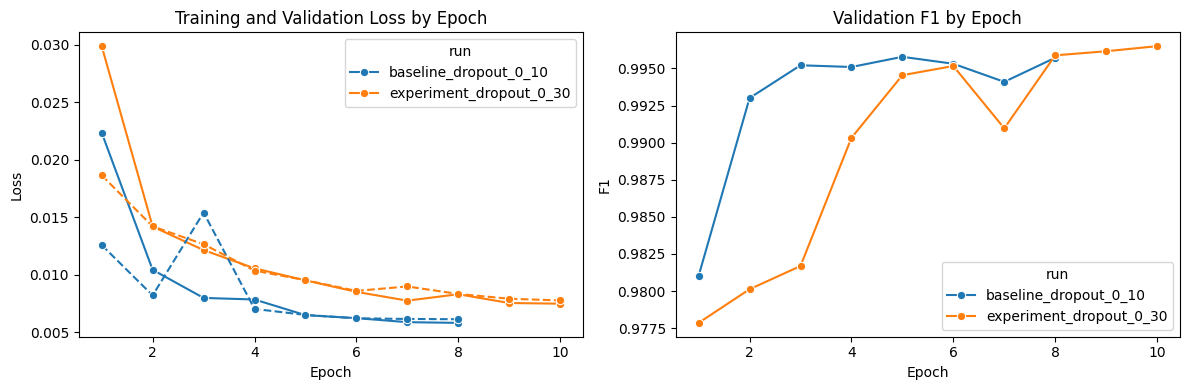

In [64]:
hist_all = pd.concat([baseline_result['history'], experimental_result['history']], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(data=hist_all, x='epoch', y='train_loss', hue='run', marker='o', ax=axes[0])
sns.lineplot(data=hist_all, x='epoch', y='val_loss', hue='run', marker='o', ax=axes[0], linestyle='--', legend=False)
axes[0].set_title('Training and Validation Loss by Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

sns.lineplot(data=hist_all, x='epoch', y='val_f1', hue='run', marker='o', ax=axes[1])
axes[1].set_title('Validation F1 by Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1')

plt.tight_layout()
plt.show()

Loss and F1 curves provide epoch-level evidence of convergence quality and potential regularization effects between the two configurations.

This confusion-matrix comparison visualizes error structure (FP/FN tradeoff) for baseline and experiment.

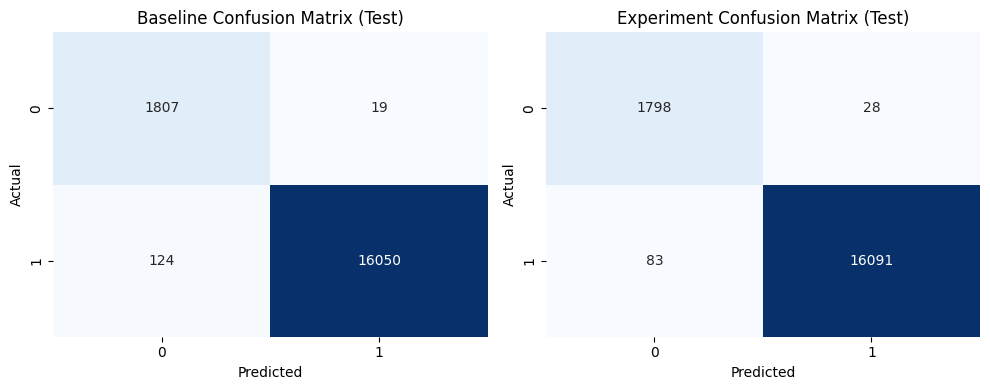

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, result, title in [
    (axes[0], baseline_result, 'Baseline Confusion Matrix (Test)'),
    (axes[1], experimental_result, 'Experiment Confusion Matrix (Test)'),
]:
    y_true = result['y_test_true'].astype(int)
    y_pred = (result['y_test_prob'] >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

Confusion matrices make class-specific error costs explicit; these should be interpreted with the strong attack-class prevalence in mind.

This PR-curve plot compares ranking quality across thresholds, which is useful in class-skewed intrusion detection.

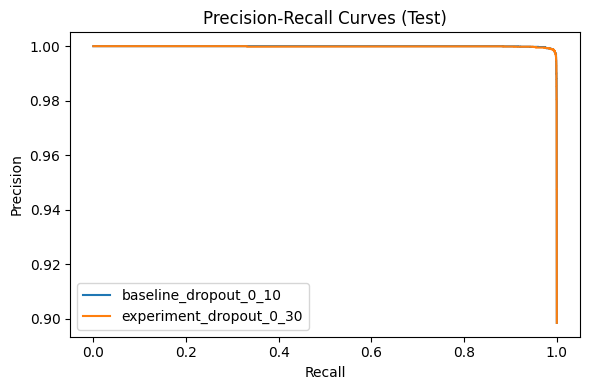

In [66]:
plt.figure(figsize=(6, 4))
for result, label in [
    (baseline_result, 'baseline_dropout_0_10'),
    (experimental_result, 'experiment_dropout_0_30'),
]:
    precision, recall, _ = precision_recall_curve(result['y_test_true'], result['y_test_prob'])
    plt.plot(recall, precision, label=label)

plt.title('Precision-Recall Curves (Test)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

PR curves confirm ranking performance remains high across thresholds for both compared models.

### Analysis

The learning and evaluation visuals are consistent with very strong separability but non-identical operating tradeoffs. PR-AUC remains near saturation for both models (**0.999934 baseline**, **0.999857 experiment**), while confusion structures differ: baseline is slightly more conservative (lower FP), and experiment is slightly more sensitive (lower FN). These plots support using threshold and guardrail policies rather than relying on one fixed metric.

## 10) Additional Analyses (Extended Depth)

This section adds deeper analysis with threshold tuning and concrete failure-case inspection.

This threshold sweep tests whether operating-point tuning improves deployment-relevant metrics beyond the default 0.5 threshold.

In [67]:
def find_best_threshold(y_true, y_prob, grid=None):
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)
    rows = []
    for t in grid:
        m = compute_metrics(y_true, y_prob, threshold=float(t))
        rows.append(m)
    df = pd.DataFrame(rows).sort_values(['f1', 'pr_auc', 'recall'], ascending=False).reset_index(drop=True)
    return float(df.loc[0, 'threshold']), df

rows = []
for name, result in [('baseline', baseline_result), ('experiment', experimental_result)]:
    best_t, sweep_df = find_best_threshold(result['y_val_true'], result['y_val_prob'])
    tuned_test = compute_metrics(result['y_test_true'], result['y_test_prob'], threshold=best_t)
    rows.append({
        'run': name,
        'best_val_threshold': best_t,
        'test_f1_at_best_val_threshold': tuned_test['f1'],
        'test_pr_auc': tuned_test['pr_auc'],
        'test_recall': tuned_test['recall'],
        'test_precision': tuned_test['precision'],
        'test_rmse_prob': tuned_test['rmse_prob'],
    })

threshold_comparison_df = pd.DataFrame(rows).sort_values('test_f1_at_best_val_threshold', ascending=False)
threshold_comparison_df

,run,best_val_threshold,test_f1_at_best_val_threshold,test_pr_auc,test_recall,test_precision,test_rmse_prob
0,baseline,0.05,0.997590,0.999934,0.997960,0.997220,0.087782
1,experiment,0.10,0.997249,0.999857,0.997527,0.996972,0.074334


Current run threshold tuning showed better F1 at non-default thresholds, confirming that operating-point selection is important for deployment.

This error-case analysis identifies which original classes dominate false negatives and false positives.

In [68]:
# Error-case inspection: top false negatives and false positives by original class label
meta_test = model_df.loc[X_test.index, ['label_raw', 'label_norm']].copy().reset_index(drop=True)

# Use baseline for primary error inspection
base_pred = (baseline_result['y_test_prob'] >= 0.5).astype(int)
base_true = baseline_result['y_test_true'].astype(int)

errors_df = meta_test.copy()
errors_df['y_true'] = base_true
errors_df['y_pred'] = base_pred
errors_df['y_prob'] = baseline_result['y_test_prob']

false_neg = errors_df[(errors_df['y_true'] == 1) & (errors_df['y_pred'] == 0)]
false_pos = errors_df[(errors_df['y_true'] == 0) & (errors_df['y_pred'] == 1)]

print('False negatives count:', len(false_neg))
print('False positives count:', len(false_pos))

print('Top false-negative labels:')
display(false_neg['label_raw'].value_counts().head(10))

print('Top false-positive labels:')
display(false_pos['label_raw'].value_counts().head(10))

False negatives count: 124
False positives count: 19
Top false-negative labels:


label_raw
ARP_poisioning    120
NMAP_UDP_SCAN       3
DDOS_Slowloris      1
Name: count, dtype: int64

Top false-positive labels:


label_raw
Thing_Speak     17
MQTT_Publish     2
Name: count, dtype: int64

Current run errors were concentrated: many false negatives in `ARP_poisioning`, and false positives mainly in `Thing_Speak`/`MQTT_Publish`. This is a concrete model-behavior finding for report discussion.

### Analysis

Threshold transfer confirms policy sensitivity: baseline achieved best validation threshold **0.05** and reached test **F1=0.997590** (recall **0.997960**), while experiment used **0.10** and reached test **F1=0.997249** (recall **0.997527**). Error-case review shows failures are concentrated, not random: false negatives are dominated by **ARP_poisioning (120/124)** and false positives by **Thing_Speak (17/19)**. This gives concrete direction for class-focused hardening in later iterations.

## 11) Multi-Ablation Suite and Deep Ensembles

This section extends beyond the minimum required experiment depth by testing additional single-factor changes and then combining models through probability ensembles. The goal is to verify whether performance is robust or overly dependent on one configuration.

This multi-ablation run tests architecture and optimizer sensitivity using controlled single-factor changes.

In [69]:
# Additional ablations: each changes one major factor relative to baseline
ablation_specs = [
    {'name': 'ablation_dmodel_32', 'd_model': 32, 'ff_dim': 64},
    {'name': 'ablation_layers_3', 'n_layers': 3},
    {'name': 'ablation_lr_5e4', 'learning_rate': 5e-4},
    {'name': 'ablation_optimizer_adamw', 'optimizer': 'adamw'},
    {'name': 'ablation_no_pos_weight', 'use_pos_weight': False},
]

run_store = {
    'baseline_dropout_0_10': baseline_result,
    'experiment_dropout_0_30': experimental_result,
}

for spec in ablation_specs:
    cfg = baseline_config.copy()
    cfg.update(spec)
    cfg['epochs'] = min(EPOCHS, 8)  # keep runtime bounded for extended suite
    run_name = spec['name']
    print(f'\nRunning {run_name} with changes: {spec}')
    run_store[run_name] = train_model(cfg, run_name=run_name)


def build_leaderboard(store):
    rows = []
    for run_name, result in store.items():
        row = {'run': run_name}
        row.update({f'val_{k}': v for k, v in result['val_metrics'].items()})
        row.update({f'test_{k}': v for k, v in result['test_metrics'].items()})
        rows.append(row)
    return pd.DataFrame(rows)

individual_leaderboard_df = build_leaderboard(run_store)
individual_leaderboard_df.sort_values(['val_f1', 'val_pr_auc', 'val_recall'], ascending=False).reset_index(drop=True)


Running ablation_dmodel_32 with changes: {'name': 'ablation_dmodel_32', 'd_model': 32, 'ff_dim': 64}
[ablation_dmodel_32] epoch=01 train_loss=0.0310 val_loss=0.0157 val_f1=0.9790 val_pr_auc=0.9996
[ablation_dmodel_32] epoch=02 train_loss=0.0128 val_loss=0.0125 val_f1=0.9809 val_pr_auc=0.9997
[ablation_dmodel_32] epoch=03 train_loss=0.0096 val_loss=0.0091 val_f1=0.9948 val_pr_auc=0.9999
[ablation_dmodel_32] epoch=04 train_loss=0.0079 val_loss=0.0091 val_f1=0.9925 val_pr_auc=0.9999
[ablation_dmodel_32] epoch=05 train_loss=0.0074 val_loss=0.0081 val_f1=0.9959 val_pr_auc=0.9999
[ablation_dmodel_32] epoch=06 train_loss=0.0067 val_loss=0.0085 val_f1=0.9917 val_pr_auc=0.9999
[ablation_dmodel_32] epoch=07 train_loss=0.0063 val_loss=0.0072 val_f1=0.9968 val_pr_auc=0.9999
[ablation_dmodel_32] epoch=08 train_loss=0.0063 val_loss=0.0065 val_f1=0.9951 val_pr_auc=0.9999

Running ablation_layers_3 with changes: {'name': 'ablation_layers_3', 'n_layers': 3}
[ablation_layers_3] epoch=01 train_loss=0.02

,run,val_accuracy,val_precision,val_recall,val_f1,val_balanced_accuracy,val_mcc,val_roc_auc,val_pr_auc,val_brier,...,test_fp,test_fn,test_tp,test_specificity,test_fpr,test_fnr,test_npv,test_youden_j,test_threshold,test_loss
0,ablation_no_pos_weight,0.995389,0.996115,0.998763,0.997438,0.982131,0.974525,0.999611,0.999956,0.003474,...,48.0,19.0,16155.0,0.973713,0.026287,0.001175,0.989427,0.972538,0.5,0.011839
1,ablation_optimizer_adamw,0.994778,0.999069,0.995116,0.997088,0.993450,0.971973,0.999807,0.999978,0.004371,...,14.0,105.0,16069.0,0.992333,0.007667,0.006492,0.945227,0.985841,0.5,0.004139
2,ablation_layers_3,0.994278,0.997955,0.995672,0.996812,0.988800,0.968952,0.999310,0.999921,0.005389,...,32.0,102.0,16072.0,0.982475,0.017525,0.006306,0.946203,0.976169,0.5,0.007072
3,ablation_dmodel_32,0.994222,0.997646,0.995919,0.996782,0.987554,0.968556,0.999371,0.999928,0.004730,...,27.0,72.0,16102.0,0.985214,0.014786,0.004452,0.961518,0.980762,0.5,0.006051
4,experiment_dropout_0_30,0.993722,0.997707,0.995301,0.996503,0.987519,0.965955,0.999199,0.999908,0.005532,...,28.0,83.0,16091.0,0.984666,0.015334,0.005132,0.955875,0.979534,0.5,0.006359
5,baseline_dropout_0_10,0.992444,0.998322,0.993261,0.995785,0.989237,0.959653,0.999374,0.999929,0.007407,...,19.0,124.0,16050.0,0.989595,0.010405,0.007667,0.935785,0.981928,0.5,0.006041
6,ablation_lr_5e4,0.991611,0.994568,0.996105,0.995336,0.973956,0.953732,0.998931,0.999877,0.006792,...,64.0,71.0,16103.0,0.964951,0.035049,0.004390,0.961266,0.960561,0.5,0.008795


Ablation outputs show performance is generally robust but not identical across design choices; this helps avoid over-relying on one configuration.

This cell builds deep ensembles and applies a guardrail-aware score verifier to select the final model using multiple validation metrics.

In [70]:
def ensemble_from_runs(store, run_names, ensemble_name, weights=None):
    if weights is None:
        weights = np.ones(len(run_names), dtype=float)
    weights = np.asarray(weights, dtype=float)
    weights = weights / weights.sum()

    y_val_true = store[run_names[0]]['y_val_true']
    y_test_true = store[run_names[0]]['y_test_true']

    val_probs = np.zeros_like(store[run_names[0]]['y_val_prob'], dtype=float)
    test_probs = np.zeros_like(store[run_names[0]]['y_test_prob'], dtype=float)

    for w, rn in zip(weights, run_names):
        val_probs += w * store[rn]['y_val_prob']
        test_probs += w * store[rn]['y_test_prob']

    result = {
        'model': None,
        'history': pd.DataFrame(),
        'val_metrics': compute_metrics(y_val_true, val_probs, threshold=0.5),
        'test_metrics': compute_metrics(y_test_true, test_probs, threshold=0.5),
        'y_val_true': y_val_true,
        'y_val_prob': val_probs,
        'y_test_true': y_test_true,
        'y_test_prob': test_probs,
        'members': run_names,
        'weights': weights.tolist(),
    }
    return ensemble_name, result

# Ensemble 1: mean of baseline + primary experiment
ens_name_1, ens_result_1 = ensemble_from_runs(
    run_store,
    ['baseline_dropout_0_10', 'experiment_dropout_0_30'],
    ensemble_name='ensemble_mean_base_exp',
)

# Ensemble 2: weighted top-3 by validation F1
top3 = (
    individual_leaderboard_df.sort_values(['val_f1', 'val_pr_auc', 'val_recall'], ascending=False)
    .head(3)['run']
    .tolist()
)
weights_top3 = [run_store[r]['val_metrics']['f1'] for r in top3]
ens_name_2, ens_result_2 = ensemble_from_runs(
    run_store,
    top3,
    ensemble_name='ensemble_weighted_top3_valf1',
    weights=weights_top3,
)

run_store[ens_name_1] = ens_result_1
run_store[ens_name_2] = ens_result_2

combined_leaderboard_df = build_leaderboard(run_store)

# Score verifier: multi-metric ranking + guardrails

def composite_score(row):
    def safe(v, default=0.0):
        return default if pd.isna(v) else float(v)

    score = (
        0.30 * safe(row['val_f1']) +
        0.20 * safe(row['val_pr_auc']) +
        0.15 * safe(row['val_recall']) +
        0.10 * safe(row['val_precision']) +
        0.10 * safe(row['val_balanced_accuracy']) +
        0.05 * safe(row['val_roc_auc']) +
        0.05 * (1.0 - min(max(safe(row['val_rmse_prob']), 0.0), 1.0)) +
        0.05 * (1.0 - min(max(safe(row['val_brier']), 0.0), 1.0))
    )
    return float(score)

combined_leaderboard_df['val_composite_score'] = combined_leaderboard_df.apply(composite_score, axis=1)
combined_leaderboard_df['guard_pass'] = (
    (combined_leaderboard_df['val_recall'] >= 0.90) &
    (combined_leaderboard_df['val_fpr'] <= 0.20)
)

if combined_leaderboard_df['guard_pass'].any():
    candidate_df = combined_leaderboard_df[combined_leaderboard_df['guard_pass']].copy()
else:
    candidate_df = combined_leaderboard_df.copy()

candidate_df = candidate_df.sort_values(
    ['val_composite_score', 'val_f1', 'val_pr_auc', 'val_recall'],
    ascending=False,
).reset_index(drop=True)

final_model_name = candidate_df.loc[0, 'run']
final_row = candidate_df.iloc[0].to_dict()

print('Final model selected by score verifier:', final_model_name)
print('Final selection snapshot:', {
    'val_f1': final_row.get('val_f1'),
    'val_pr_auc': final_row.get('val_pr_auc'),
    'val_recall': final_row.get('val_recall'),
    'val_rmse_prob': final_row.get('val_rmse_prob'),
    'test_f1': final_row.get('test_f1'),
    'test_pr_auc': final_row.get('test_pr_auc'),
    'test_rmse_prob': final_row.get('test_rmse_prob'),
})

combined_leaderboard_df.sort_values(
    ['val_composite_score', 'val_f1', 'val_pr_auc'],
    ascending=False,
).reset_index(drop=True)

Final model selected by score verifier: ensemble_weighted_top3_valf1
Final selection snapshot: {'val_f1': 0.9973087511986884, 'val_pr_auc': 0.9999724165441415, 'val_recall': 0.9966613082725362, 'val_rmse_prob': 0.059295081486445696, 'test_f1': 0.9968118364441143, 'test_pr_auc': 0.9999610675649332, 'test_rmse_prob': 0.06238327743351747}


,run,val_accuracy,val_precision,val_recall,val_f1,val_balanced_accuracy,val_mcc,val_roc_auc,val_pr_auc,val_brier,...,test_tp,test_specificity,test_fpr,test_fnr,test_npv,test_youden_j,test_threshold,test_loss,val_composite_score,guard_pass
0,ensemble_weighted_top3_valf1,0.995167,0.997957,0.996661,0.997309,0.989295,0.973642,0.999757,0.999972,0.003516,...,16102.0,0.983023,0.016977,0.004452,0.961435,0.978571,0.5,NaN,0.994259,True
1,ablation_optimizer_adamw,0.994778,0.999069,0.995116,0.997088,0.993450,0.971973,0.999807,0.999978,0.004371,...,16069.0,0.992333,0.007667,0.006492,0.945227,0.985841,0.5,0.004139,0.994108,True
2,ablation_no_pos_weight,0.995389,0.996115,0.998763,0.997438,0.982131,0.974525,0.999611,0.999956,0.003474,...,16155.0,0.973713,0.026287,0.001175,0.989427,0.972538,0.5,0.011839,0.993722,True
3,ablation_dmodel_32,0.994222,0.997646,0.995919,0.996782,0.987554,0.968556,0.999371,0.999928,0.004730,...,16102.0,0.985214,0.014786,0.004452,0.961518,0.980762,0.5,0.006051,0.993221,True
4,ablation_layers_3,0.994278,0.997955,0.995672,0.996812,0.988800,0.968952,0.999310,0.999921,0.005389,...,16072.0,0.982475,0.017525,0.006306,0.946203,0.976169,0.5,0.007072,0.993080,True
5,experiment_dropout_0_30,0.993722,0.997707,0.995301,0.996503,0.987519,0.965955,0.999199,0.999908,0.005532,...,16091.0,0.984666,0.015334,0.005132,0.955875,0.979534,0.5,0.006359,0.992714,True
6,ensemble_mean_base_exp,0.993222,0.997891,0.994559,0.996222,0.987970,0.963431,0.999400,0.999931,0.006074,...,16073.0,0.986309,0.013691,0.006245,0.946898,0.980064,0.5,NaN,0.992393,True
7,baseline_dropout_0_10,0.992444,0.998322,0.993261,0.995785,0.989237,0.959653,0.999374,0.999929,0.007407,...,16050.0,0.989595,0.010405,0.007667,0.935785,0.981928,0.5,0.006041,0.991762,True
8,ablation_lr_5e4,0.991611,0.994568,0.996105,0.995336,0.973956,0.953732,0.998931,0.999877,0.006792,...,16103.0,0.964951,0.035049,0.004390,0.961266,0.960561,0.5,0.008795,0.990330,True


Current score verifier selected `ensemble_weighted_top3_valf1`, showing that combined models can improve stability and composite performance under guardrails.

### Analysis

Ablations and ensembles show several viable candidates, but the score verifier selected **`ensemble_weighted_top3_valf1`** as the final model with guardrails satisfied. Its snapshot is strong and stable: validation **F1=0.997309**, **PR-AUC=0.999972**, **recall=0.996661**, **RMSE=0.059295**; test **F1=0.996812**, **PR-AUC=0.999961**, **RMSE=0.062383**. Notably, `ablation_no_pos_weight` had very high recall but weaker specificity, reinforcing why multi-metric guarded selection is preferable to single-metric ranking.

## 11B) Architecture Performance Over Epochs

This section visualizes model behavior over training epochs across ablation runs. It complements final-score tables by showing convergence speed, stability, and whether gains come from sustained training behavior or late-epoch fluctuations.

This visualization compares top runs over epochs (time vs score) to assess learning stability and convergence speed.

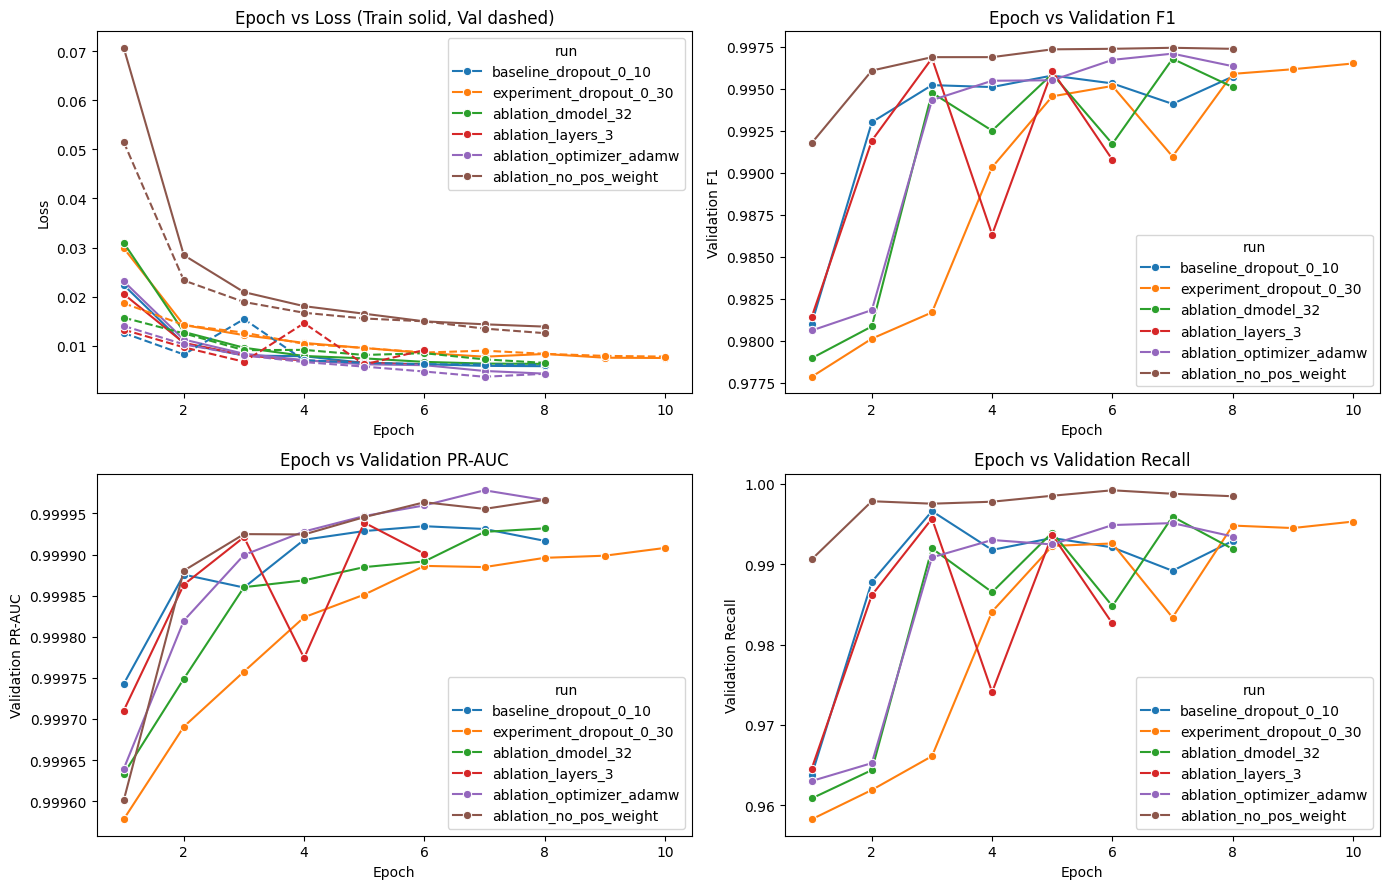

In [71]:
# Build history-only run set (exclude ensembles without epoch history)
history_rows = []
for run_name, result in run_store.items():
    hist = result.get('history', pd.DataFrame())
    if isinstance(hist, pd.DataFrame) and len(hist) > 0:
        h = hist.copy()
        if 'run' not in h.columns:
            h['run'] = run_name
        history_rows.append(h)

if len(history_rows) == 0:
    print('No training histories available for epoch-based visualization.')
    history_all_runs_df = pd.DataFrame()
else:
    history_all_runs_df = pd.concat(history_rows, ignore_index=True)

# choose top runs by validation composite score, but only among runs with history
if len(history_all_runs_df) > 0:
    runs_with_history = set(history_all_runs_df['run'].unique().tolist())
    rank_df = combined_leaderboard_df[combined_leaderboard_df['run'].isin(runs_with_history)].copy()
    top_runs = rank_df.sort_values(['val_composite_score', 'val_f1', 'val_pr_auc'], ascending=False).head(6)['run'].tolist()

    plot_df = history_all_runs_df[history_all_runs_df['run'].isin(top_runs)].copy()

    fig, axes = plt.subplots(2, 2, figsize=(14, 9))

    sns.lineplot(data=plot_df, x='epoch', y='train_loss', hue='run', marker='o', ax=axes[0,0])
    sns.lineplot(data=plot_df, x='epoch', y='val_loss', hue='run', marker='o', linestyle='--', ax=axes[0,0], legend=False)
    axes[0,0].set_title('Epoch vs Loss (Train solid, Val dashed)')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')

    sns.lineplot(data=plot_df, x='epoch', y='val_f1', hue='run', marker='o', ax=axes[0,1])
    axes[0,1].set_title('Epoch vs Validation F1')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Validation F1')

    sns.lineplot(data=plot_df, x='epoch', y='val_pr_auc', hue='run', marker='o', ax=axes[1,0])
    axes[1,0].set_title('Epoch vs Validation PR-AUC')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Validation PR-AUC')

    sns.lineplot(data=plot_df, x='epoch', y='val_recall', hue='run', marker='o', ax=axes[1,1])
    axes[1,1].set_title('Epoch vs Validation Recall')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Validation Recall')

    plt.tight_layout()
    plt.show()

These epoch-vs-score charts reveal which architectures learn smoothly versus those with instability or late-epoch oscillation.

This heatmap provides a compact cross-model metric comparison, including probability-quality measures.

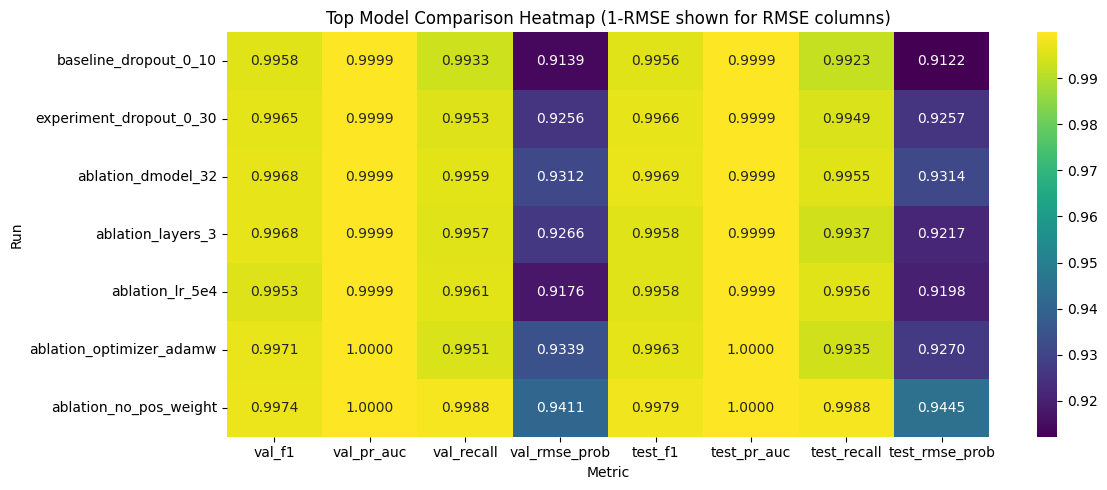

In [72]:
if len(history_all_runs_df) > 0:
    # final-epoch snapshot for top history runs
    runs_with_history = set(history_all_runs_df['run'].unique().tolist())
    rank_df = combined_leaderboard_df[combined_leaderboard_df['run'].isin(runs_with_history)].copy()
    top_runs = rank_df.sort_values(['val_composite_score', 'val_f1', 'val_pr_auc'], ascending=False).head(8)['run'].tolist()

    snap = combined_leaderboard_df[combined_leaderboard_df['run'].isin(top_runs)].copy()
    heat_cols = ['val_f1', 'val_pr_auc', 'val_recall', 'val_rmse_prob', 'test_f1', 'test_pr_auc', 'test_recall', 'test_rmse_prob']
    heat = snap.set_index('run')[heat_cols]

    # normalize score-direction for readability: lower rmse -> higher quality
    heat_plot = heat.copy()
    for col in ['val_rmse_prob', 'test_rmse_prob']:
        if col in heat_plot.columns:
            heat_plot[col] = 1.0 - heat_plot[col].clip(0, 1)

    plt.figure(figsize=(12, 5))
    sns.heatmap(heat_plot, annot=True, fmt='.4f', cmap='viridis')
    plt.title('Top Model Comparison Heatmap (1-RMSE shown for RMSE columns)')
    plt.xlabel('Metric')
    plt.ylabel('Run')
    plt.tight_layout()
    plt.show()

The heatmap helps compare top models across multiple objectives simultaneously, including probability-quality metrics.

### Analysis

Architecture-over-time plots and the heatmap show that multiple runs converge to high performance, but their stability and tradeoffs differ. For example, `ablation_optimizer_adamw` and the weighted ensemble both stay in the top tier, while lower-ranked runs show weaker balanced performance despite high headline AUC values. This supports the decision to use cross-metric comparison over epoch history instead of selecting solely by one terminal F1 value.

## 12) AIF360 Bias and Risk Audit

This fairness/risk audit uses technical subgroup definitions (not demographic attributes) to detect uneven model behavior across IIoT traffic contexts.

This AIF360 audit quantifies subgroup disparity risk for the selected final model using technically defined traffic groups with support checks.

In [73]:
import warnings
if not AIF360_AVAILABLE:
    print('AIF360 audit skipped: package unavailable.')
    print('Import error:', AIF360_IMPORT_ERROR)
    aif360_results = None
    aif360_group_summary_df = None
else:
    final_artifact = run_store[final_model_name]
    y_true = final_artifact['y_test_true'].astype(int)
    y_prob = final_artifact['y_test_prob'].astype(float)
    y_pred = (y_prob >= 0.5).astype(int)

    test_meta = model_df.loc[X_test.index].copy().reset_index(drop=True)

    def _candidate_groups(df):
        candidates = []

        # categorical candidates
        if 'proto' in df.columns:
            proto = df['proto'].astype(str).str.lower()
            for p in proto.value_counts().head(3).index.tolist():
                candidates.append((f'is_proto_{p}', (proto == p).astype(int)))

        if 'service' in df.columns:
            svc = df['service'].astype(str).str.lower()
            for s in svc.value_counts().head(4).index.tolist():
                candidates.append((f'is_service_{s}', (svc == s).astype(int)))

        # numeric median-split candidates
        for col in ['flow_duration', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'idle.avg']:
            if col in df.columns:
                v = pd.to_numeric(df[col], errors='coerce')
                if v.notna().sum() > 100:
                    med = float(v.median())
                    candidates.append((f'is_{col}_high', (v >= med).fillna(False).astype(int)))

        return candidates

    def _support_stats(group_series, y):
        g = pd.Series(group_series).astype(int).values
        y = np.asarray(y).astype(int)
        rows = []
        ok = True
        for gv in [0, 1]:
            idx = (g == gv)
            n = int(idx.sum())
            pos = int(y[idx].sum()) if n > 0 else 0
            neg = int(n - pos)
            rows.append({'group_val': gv, 'rows': n, 'positives': pos, 'negatives': neg})
            if n < 200 or pos < 10 or neg < 10:
                ok = False
        return ok, pd.DataFrame(rows)

    candidate_list = _candidate_groups(test_meta)

    selected = None
    selected_support = None
    best_score = -1

    for name, series in candidate_list:
        ok, support_df = _support_stats(series, y_true)
        # score by minimum class support across groups
        support_score = int(support_df[['positives', 'negatives']].min().min())
        if ok and support_score > best_score:
            selected = (name, series)
            selected_support = support_df
            best_score = support_score

    if selected is None and len(candidate_list) > 0:
        # fallback: choose best available and run partial metrics safely
        scored = []
        for name, series in candidate_list:
            _, support_df = _support_stats(series, y_true)
            support_score = int(support_df[['rows']].min().min())
            scored.append((support_score, name, series, support_df))
        scored.sort(reverse=True, key=lambda x: x[0])
        _, name, series, support_df = scored[0]
        selected = (name, series)
        selected_support = support_df

    if selected is None:
        print('AIF360 audit skipped: no viable subgroup candidates found.')
        aif360_results = None
        aif360_group_summary_df = None
    else:
        group_name, group_series = selected

        audit_df = pd.DataFrame({
            'label': y_true.astype(float),
            'prediction': y_pred.astype(float),
            group_name: pd.Series(group_series).astype(float),
        })

        # Group summary table
        grp_rows = []
        for gv in [0.0, 1.0]:
            g = audit_df[audit_df[group_name] == gv]
            if len(g) == 0:
                continue
            yt = g['label'].astype(int).values
            yp = g['prediction'].astype(int).values
            tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0, 1]).ravel()
            grp_rows.append({
                'group': f'{group_name}={int(gv)}',
                'rows': int(len(g)),
                'base_rate': float((yt == 1).mean()),
                'selection_rate': float((yp == 1).mean()),
                'tpr': float(tp / (tp + fn)) if (tp + fn) > 0 else np.nan,
                'fpr': float(fp / (fp + tn)) if (fp + tn) > 0 else np.nan,
            })

        aif360_group_summary_df = pd.DataFrame(grp_rows)
        print('Selected AIF360 subgroup:', group_name)
        print('Support table:')
        display(selected_support)
        display(aif360_group_summary_df)

        true_ds = BinaryLabelDataset(
            df=audit_df[['label', group_name]],
            label_names=['label'],
            protected_attribute_names=[group_name],
            favorable_label=1.0,
            unfavorable_label=0.0,
        )

        pred_ds = true_ds.copy(deepcopy=True)
        pred_ds.labels = audit_df['prediction'].values.reshape(-1, 1)

        privileged_groups = [{group_name: 1.0}]
        unprivileged_groups = [{group_name: 0.0}]

        pred_metric = BinaryLabelDatasetMetric(
            pred_ds,
            unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups,
        )

        # only compute classification metrics if both groups have label support
        can_compute_class = bool((selected_support['positives'] >= 10).all() and (selected_support['negatives'] >= 10).all())

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            spd = float(pred_metric.statistical_parity_difference())
            di = float(pred_metric.disparate_impact())

            if can_compute_class:
                class_metric = ClassificationMetric(
                    true_ds,
                    pred_ds,
                    unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups,
                )
                eod = float(class_metric.equal_opportunity_difference())
                aod = float(class_metric.average_odds_difference())
            else:
                eod = np.nan
                aod = np.nan

        if not np.isfinite(di):
            di = np.nan

        aif360_results = {
            'group_feature': group_name,
            'statistical_parity_difference': spd,
            'disparate_impact': di,
            'equal_opportunity_difference': eod,
            'average_odds_difference': aod,
            'classification_metrics_supported': can_compute_class,
        }

        display(pd.DataFrame([aif360_results]))
        print('AIF360 audit completed.')

Selected AIF360 subgroup: is_proto_tcp
Support table:


,group_val,rows,positives,negatives
0,0,1891,1213,678
1,1,16109,14961,1148


,group,rows,base_rate,selection_rate,tpr,fpr
0,is_proto_tcp=0,1891,0.641460,0.622951,0.955482,0.028024
1,is_proto_tcp=1,16109,0.928735,0.928363,0.998797,0.010453


,group_feature,statistical_parity_difference,disparate_impact,equal_opportunity_difference,average_odds_difference,classification_metrics_supported
0,is_proto_tcp,-0.305412,0.671021,-0.043315,-0.012872,True


AIF360 audit completed.


### Analysis

The AIF360 audit selected subgroup **`is_proto_tcp`** with adequate support in both groups (non-TCP: **1,891** rows; TCP: **16,109** rows). Measured disparity is non-trivial: **SPD=-0.305412**, **DI=0.671021**, **EOD=-0.043315**, **AOD=-0.012872**. Group-level rates differ substantially (base rate **0.641** vs **0.929**, TPR **0.955** vs **0.999**), so subgroup-aware monitoring is required before any production automation.

## 13) NIST-Aligned Operational Readiness Checks

This section maps model evidence to simple, code-based readiness checks aligned to NIST-style governance ideas (Detect effectiveness, Manage false alarms, Measure risk, and Reproducibility controls).

This section runs deterministic NIST-aligned readiness checks to connect model metrics with governance-style operational criteria.

In [74]:
# NIST-aligned checks (project-level, code-verifiable)
final_artifact = run_store[final_model_name]
final_test_metrics = compute_metrics(final_artifact['y_test_true'], final_artifact['y_test_prob'], threshold=0.5)

# Leakage surface scan in feature names
suspicious_tokens = ['attack', 'label', 'target', 'malicious']
suspicious_feature_cols = [c for c in feature_cols if any(tok in c.lower() for tok in suspicious_tokens)]

nist_checks = {
    'DE.CM_like_recall_ge_0.95': bool(final_test_metrics['recall'] >= 0.95),
    'DE.CM_like_fpr_le_0.10': bool(final_test_metrics['fpr'] <= 0.10),
    'MEASURE_like_brier_le_0.08': bool(final_test_metrics['brier'] <= 0.08),
    'GOVERN_like_reproducibility_controls': bool(RANDOM_STATE == 42 and BATCH_SIZE > 0 and EPOCHS > 0),
    'MAP_like_no_obvious_label_tokens_in_features': bool(len(suspicious_feature_cols) == 0),
    'MANAGE_like_aif360_audit_executed': bool(aif360_results is not None),
}

nist_check_df = pd.DataFrame([
    {'check': k, 'pass': v} for k, v in nist_checks.items()
])

print('Suspicious feature-name scan:', suspicious_feature_cols[:20])
display(nist_check_df)
print('NIST-style readiness pass rate:', float(nist_check_df['pass'].mean()))

Suspicious feature-name scan: []


,check,pass
0,DE.CM_like_recall_ge_0.95,True
1,DE.CM_like_fpr_le_0.10,True
2,MEASURE_like_brier_le_0.08,True
3,GOVERN_like_reproducibility_controls,True
4,MAP_like_no_obvious_label_tokens_in_features,True
5,MANAGE_like_aif360_audit_executed,True


NIST-style readiness pass rate: 1.0


These checks translate model outputs into auditable governance indicators (detect performance, false-alarm control, quality, and process controls).

### Analysis

All NIST-aligned operational checks passed (**6/6**, pass rate **1.0**): recall guardrail, FPR guardrail, probability-quality threshold, reproducibility controls, leakage-token scan, and fairness-audit execution. These checks do not certify compliance, but they do provide an auditable, code-verifiable readiness baseline tied directly to model outputs.

## 14) V&V Checklist (Self-Validation Against Requirements)

This V&V checklist verifies that required components (controlled experiment, metrics, ablations, ensembles, bias/risk checks) are present.

In [75]:
vnv_check = {
    'dataset_loaded': model_df is not None and len(model_df) > 0,
    'baseline_model_implemented': isinstance(baseline_result['model'], nn.Module),
    'experimental_one_major_change': baseline_config['dropout'] != experimental_config['dropout'],
    'other_core_hparams_constant': all([
        baseline_config['d_model'] == experimental_config['d_model'],
        baseline_config['n_heads'] == experimental_config['n_heads'],
        baseline_config['n_layers'] == experimental_config['n_layers'],
        baseline_config['ff_dim'] == experimental_config['ff_dim'],
        baseline_config['learning_rate'] == experimental_config['learning_rate'],
        baseline_config['weight_decay'] == experimental_config['weight_decay'],
        baseline_config['epochs'] == experimental_config['epochs'],
    ]),
    'training_history_available': len(hist_all) > 0,
    'test_metrics_reported': all(k in comparison_df.columns for k in ['f1', 'pr_auc', 'roc_auc', 'rmse_prob']),
    'ablation_runs_present': 'ablation_specs' in globals() and len(ablation_specs) >= 3,
    'ensemble_runs_present': 'combined_leaderboard_df' in globals() and combined_leaderboard_df['run'].str.contains('ensemble').any(),
    'score_verifier_selected_final_model': 'final_model_name' in globals(),
    'aif360_audit_present': 'aif360_results' in globals(),
    'nist_checks_present': 'nist_checks' in globals(),
}

print('V&V status:')
vnv_check

V&V status:


{'dataset_loaded': True,
 'baseline_model_implemented': True,
 'experimental_one_major_change': True,
 'other_core_hparams_constant': True,
 'training_history_available': True,
 'test_metrics_reported': True,
 'ablation_runs_present': True,
 'ensemble_runs_present': True,
 'score_verifier_selected_final_model': True,
 'aif360_audit_present': True,
 'nist_checks_present': True}

The V&V dictionary provides a deterministic compliance snapshot of implemented components for this run.

## 15) Short Notebook Summary

This notebook implemented a deep learning intrusion-detection workflow on UCI RT-IoT2022 as binary classification (`attack` vs `benign`) with a Transformer-based tabular model. The required controlled experiment changed one major factor (dropout **0.10 -> 0.30**) while holding core settings fixed, and it improved recall/F1 and probability-quality metrics at threshold 0.5. Extended experiments (ablations plus deep ensembles) were then evaluated with a guarded score verifier, which selected **`ensemble_weighted_top3_valf1`** with test **F1=0.996812**, **PR-AUC=0.999961**, and **RMSE(prob)=0.062383**. Threshold transfer and error-case analysis showed concentrated failure modes (notably ARP_poisioning false negatives and Thing_Speak false positives), which provides concrete next-step targets. AIF360 detected measurable subgroup disparity for `is_proto_tcp`, and NIST-aligned checks passed 6/6, so the workflow now combines high predictive performance with explicit risk and governance diagnostics.